In [ ]:
import os
import re
from collections import defaultdict as df
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
poems = [];ic = 0
for fn in os.listdir("/content/dbh"):
    with open("/content/dbh/" + fn, 'r') as kf:
        ekkav = kf.read().strip().split('\n')[2:-1]
        for i in range(len(ekkav)):
            if ekkav[i][0]==' ': ekkav[i] = '<sep>'
        ekkav = '\n'.join(ekkav).split('<sep>')
        for i in range(len(ekkav)):
            if len(ekkav[i])>0:
                x = ekkav[i]
                for i in ",.|\'\"":
                    x = x.replace(i, '')
                a = x.strip().split('\n')
                for j in range(0,len(a),4):
                    x = a[j:j+4]
                    if len(x) is 4:
                        poems.append((' <sep> '.join(x) + ' <sep>').split())


In [ ]:
len(poems)

9408

In [ ]:
poems = poems[:5000]

In [ ]:
vocab = df(int)
for p in poems:
    for w in p: vocab[w]+=1

In [ ]:
vocab_size = len(vocab)

In [ ]:
vocab_size

2200

In [ ]:
tokenizer = {w:i+1 for i,w in enumerate(vocab.keys())}

In [ ]:
idx_to_word = {v:k for k,v in tokenizer.items()}

In [ ]:
input_sequences = []
for line in poems:
	token_list = [tokenizer[w] for w in line]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)
  
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=vocab_size + 1)

In [ ]:
print([idx_to_word[w] for w in predictors[4] if w in idx_to_word],idx_to_word[np.argmax(label[4])])
print(poems[0][:6])

['धूप', 'बहुत', 'है', 'मौसम', 'जल'] थल
['धूप', 'बहुत', 'है', 'मौसम', 'जल', 'थल']


In [ ]:
import requests

In [ ]:
with open('cc.hi.300.vec.gz', 'wb') as hv:
    hv.write(requests.get("http://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz").content)
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
# https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
# !cp "/content/cc.hi.300.vec.gz" "/content/drive/My Drive/hindpoet/"

In [ ]:
# !cp "/content/drive/My Drive/hindpoet/cc.hi.300.vec.gz" "/content/"

In [ ]:
import gzip

In [ ]:
import shutil
with gzip.open("/content/cc.hi.300.vec.gz", 'rb') as f_in:
    with open("/content/cc.hi.300.vec", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
# !cp "/content/cc.hi.300.vec" "/content/drive/My Drive/hindpoet/"

In [ ]:
def read_in_chunks(file_object, chunk_size=10*1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

embedding_matrix = np.zeros((vocab_size+1,300))

with open('/content/cc.hi.300.vec','r') as ff:
    i = 0 
    for piece in read_in_chunks(ff):
        for j in piece.split('\n'):
            try:
                float(j.split()[0])
                # print(j.split()[0])
            except: 
                data = j.split()
                if len(data)==301:
                    if data[0] in tokenizer:
                        embedding_matrix[tokenizer[data[0]]] = np.array(data[1:] ,dtype=np.float)

In [ ]:
len(embedding_matrix[5])

300

In [ ]:
import pickle
with open('embedding_matrix_32.pkl','wb') as f:
    pickle.dump(embedding_matrix, f)

In [ ]:
!cp "/content/embedding_matrix_32.pkl" "/content/drive/My Drive/hindpoet/"

In [ ]:
with open("/content/drive/My Drive/hindpoet/w2i_32.pkl", 'wb') as p:
    pickle.dump(tokenizer, p)

In [ ]:
with open("/content/drive/My Drive/hindpoet/i2w_32.pkl", 'wb') as p:
    pickle.dump(idx_to_word, p)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size + 1, 300, input_length=max_sequence_len-1, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dense(vocab_size/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(vocab_size+1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 43, 300)           660300    
_________________________________________________________________
dropout (Dropout)            (None, 43, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dense (Dense)                (None, 1100)              282700    
_________________________________________________________________
dense_1 (Dense)              (None, 2201)              2423301   
Total params: 3,936,669
Trainable params: 3,276,369
Non-trainable params: 660,300
_________________________________________________________________
None


Epoch 1/5
3857/3857 [==============================] - 27s 7ms/step - loss: 5.5782 - accuracy: 0.1560
Epoch 2/5
3857/3857 [==============================] - 27s 7ms/step - loss: 4.0701 - accuracy: 0.2718
Epoch 3/5
3857/3857 [==============================] - 26s 7ms/step - loss: 2.1745 - accuracy: 0.6230
Epoch 4/5
3857/3857 [==============================] - 26s 7ms/step - loss: 1.1803 - accuracy: 0.8437
Epoch 5/5
3857/3857 [==============================] - 26s 7ms/step - loss: 0.7797 - accuracy: 0.9174


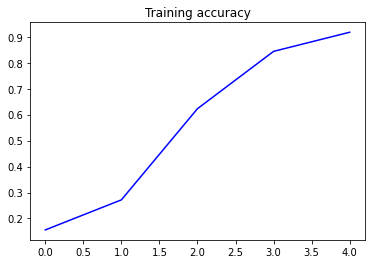

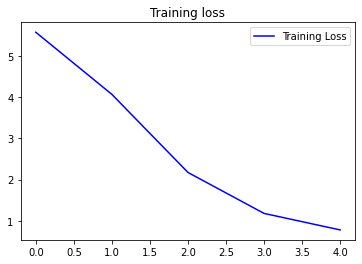

In [ ]:
history = model.fit(predictors, label, epochs=5, verbose=1)
model.save('/content/drive/My Drive/hindpoet/hindipoet32_5.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Epoch 1/5
3857/3857 [==============================] - 27s 7ms/step - loss: 0.6147 - accuracy: 0.9389
Epoch 2/5
3857/3857 [==============================] - 27s 7ms/step - loss: 0.5085 - accuracy: 0.9487
Epoch 3/5
3857/3857 [==============================] - 27s 7ms/step - loss: 0.5340 - accuracy: 0.9383
Epoch 4/5
3857/3857 [==============================] - 26s 7ms/step - loss: 0.4809 - accuracy: 0.9448
Epoch 5/5
3857/3857 [==============================] - 26s 7ms/step - loss: 0.4073 - accuracy: 0.9602


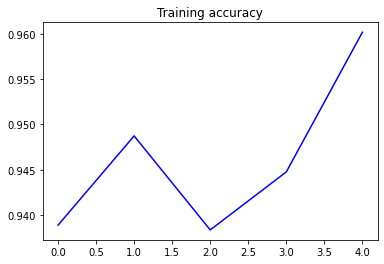

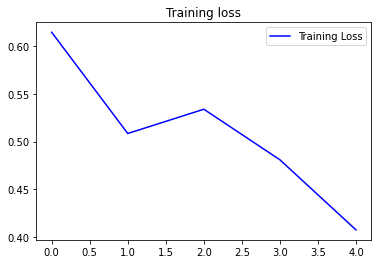

In [ ]:
history = model.fit(predictors, label, epochs=5, verbose=1)
model.save('/content/drive/My Drive/hindpoet/hindipoet32_10.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Epoch 1/2
3857/3857 [==============================] - 27s 7ms/step - loss: 0.3953 - accuracy: 0.9569
Epoch 2/2
3857/3857 [==============================] - 26s 7ms/step - loss: 0.4294 - accuracy: 0.9502


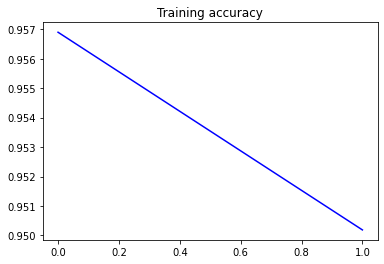

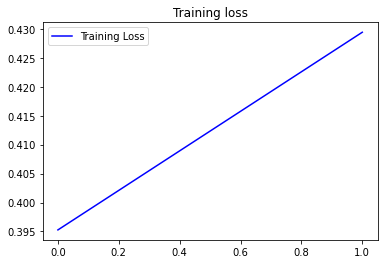

In [ ]:
history = model.fit(predictors, label, epochs=2, verbose=1)
model.save('/content/drive/My Drive/hindpoet/hindipoet32_12.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/hindpoet/hindipoet32_10.h5')

In [ ]:
def gen_poem(model, length, w2i, i2w, start = ' ', lines = 4):
    ipseq = [w2i[s] for s in start if s in w2i]
    # print(ipseq)
    lsc = 0 
    while lsc<lines:
        ip = np.array(pad_sequences([ipseq], maxlen=length, padding='pre'))
        # print(ip)
        w = model.predict(ip)[0]
        w = np.argmax(w)
        if i2w[w].strip() == '<sep>':
            lsc+=1
        start+=' '+ i2w[w] 
        ipseq.append(w)
    for i in start.split('<sep>'):
        print(i.strip(), end=  '\n\n')

In [ ]:
def gen_poem_random(model, length, w2i, i2w, start = ' ', lines = 4):
    ipseq = [w2i[s] for s in start if s in w2i]
    # print(ipseq)
    lsc = 0 
    while lsc<lines:
        ip = np.array(pad_sequences([ipseq], maxlen=length, padding='pre'))
        # print(ip)
        w = model.predict(ip)[0]
        w = np.random.choice(np.arange(vocab_size+1), p = w)
        if w is 0 or w is w2i['']: w+=1
        if i2w[w].strip() == '<sep>':
            lsc+=1
        start+=' '+ i2w[w] 
        ipseq.append(w)
    for i in start.split('<sep>'):
        print(i.strip(), end=  '\n\n')

In [ ]:
gen_poem(model, max_sequence_len-1, tokenizer, idx_to_word, "बादल", 4)

बादल से चाँद का चेहरा छूता है

बेटा ! इतनी सस्ती जन्नत नहीं होती

बाजारों में ढूंढ रहा हूँ वो चीज़े

जिन चीजों की कोई कीमत नहीं होती





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "दुनिया को छोड़ना चाहा", 3)

दुनिया को छोड़ना चाहा हैं ओढ़ कर ख़ुद को

अब ज़रूरत नहीं रज़ाई की

अक्सर चूमती हैं मेरे क़दम





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "दुनिया को छोड़ना चाहा", 4)

दुनिया को छोड़ना चाहा ऐ सूरज तुझे पूजा नहीं समझा तो है

मेरे हिस्से में भी थोड़ी धूप आनी चाहिए

मेरी क़ीमत कौन दे सकता है इस बाज़ार में

तुम ज़ुलेख़ा हो तुम्हें क़ीमत लगानी चाहिए





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "तुम्हें समुंदर में छोड़ना", 4)

तुम्हें समुंदर में छोड़ना बादल ने

याद जुदाई में एक मंज़र करते



किनारे के शुरूआत से पहले करते





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "मेरा ज़माना", 4)

मेरा ज़माना एक कहानी तस्वीर है

से क्या पास है कि उदास क्या है

कितने आज साहिबे ही नहीं है इस सदियों उड़ जाते

मैं ऐ ख़ुदा आँखों बता नज़र और उठाया है





In [ ]:
gen_poem(model, max_sequence_len-1, tokenizer, idx_to_word, "सस्ती जन्नत", 4)

सस्ती जन्नत कर गये सब किनारा कश्ती से

सिर्फ़ इक बादवन लिपटा है

दे तवानाईयां मेरे माबूद !

सभी माने ख़ुशामद तू





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "हाथी-घोड़े", 4)

हाथी-घोड़े ठहरे बंजारे हम बंजारों को

दरवाज़ों और दीवारों से क्या लेना

ख़्वाबों वाली कोई चीज़ नहीं मिलती

सोच रहा हूँ बाज़ारों से क्या लेना





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "हाथी-घोड़े", 2)

हाथी-घोड़े कितने टाल देना था मुझे भी

ख़ता क्यूँ हो गए सरकार मेरे





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "आँखों", 2)

आँखों रहा है हुजरा जंग सब

पूछेंगे अब कम होगा हो जाए





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "अब कम होगा", 2)

अब कम होगा थीं गई सब ग़ैर-ज़रूरी हँसते रहते हैं हम फूलों की नादानी है

हाय ये दुनिया! हाय ये लोग





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "ग़ैर-ज़रूरी लोग", 3)

ग़ैर-ज़रूरी लोग कितने खानों में बंट गए हम तुम

कितनी हिस्सों में बंट गई दुनिया

जब भी दुनिया को छोड़ना चाहा





In [ ]:
gen_poem_random(model, max_sequence_len-1, tokenizer, idx_to_word, "ग़ैर-ज़रूरी लोग ज़िंदगी किस तरह गुज़ारते हैं", 4)

ग़ैर-ज़रूरी लोग ज़िंदगी किस तरह गुज़ारते हैं जलाये तो अंजाम क्या हुआ मेरा

लिखा है तेज हवाओं ने मर्सिया मेरा

कहीं शरीफ नमाज़ी कहीं फ़रेबी सा

कबीला मेरा नसब बहुत सिलसिला मेरा



